# Introduction

This notebook will go through the process to calculate interaction metrics in the stressor experiments. The work here is inspired by multiple papers by Tekin et al. ([2016](https://www.nature.com/articles/s41540-018-0069-9#Sec19),[2018](https://royalsocietypublishing.org/doi/10.1098/rsif.2016.0332)).

Overall the goal is to determine the emergent interaction for the set of chemicals $x$, $I_{x}$ from from observations of population growth under all combinations of these stressors $r_{x_k} \forall \ k \in [1,N]$ (where $x_k$ denotes the set of unique combinations of $k$ elements of $x$ and $N$ is the total number of number of stressors in $x$). 

## pairwise case
For pairs of stressors this problem is trivial and we can easily write the emergent interaction by considering the observed growth under both stressors. 

First for the additive case:

$$
    r_{12} = r_{\text{control}} + (I_{1} + I_{2}) + I_{12},
$$

where interaction terms give the additive effects of a given stressor (or set of stressors) the interaction term can be calulated as:

$$
    I_{12} = r_{12} - r_{\text{control}} - (I_{1} + I_{2}).
$$

For the multiplicative case:

$$
    r_{12} = r_{\text{control}} I_{1} I_{2} I_{12},
$$

where interaction terms give the proportional change in growth. the emergent interaction can be calculated as:

$$
    I_{12} = \frac{r_{12}}{r_{\text{control}} I_{1} I_{2}}
$$


## Higher orders

Whist simple counting these terms manually quickly becomes unfeasible as we increase the number of stressors. For example the additive case for three stressors is:

$$
    r_{123} = r_{\text{control}} + (I_1 + I_2 + I_3) + (I_{12} + I_{23} + I_{31}) + I_{123}
$$

and four:

\begin{align}
    r_{1234} = r_{\text{control}} &+ (I_1 + I_2 + I_3 + I_4) \\
        &+ (I_{12} + I_{13} + I_{14} + I_{23} + I_{24} + I_{34}) \\
        &+ (I_{123} + I_{124} + I_{134} + I_{234} \\
        &+ I_{1234}
\end{align}

Furthermore, it is not enough to simply consider the difference between two levels to determine the interaction.

## Algorithmic approach
The solution to this problem is take an algorthmic approach, recognising the fact that to know the interaction term with a given number of stressors requires only that we know the interaction terms of the subsets of that combination. This allows us to calculate the interaction emergent coefficents by moving up through subsets of different size. 

The algorithm to determine all emergent interactions between all subsets of $N$ stressors is thus as follows:
1) __Determine all unique subsets of different sizes of the set of $N$ stressors__
    - This is equivalent to determining the set $x_k \forall \ k \in [1,N]$ in the notation above.
2) __Calculate the complexity of these subsets defined as their size (i.e. the number of stressors present)__
    - first the control then with 1 stressor and so on
3) __Loop over these subsets in order of complexity denoted here as $l$__ 
    * if Interactions are additive
        * if l = 0 
            * $I_{\text{control}} = 0$ 
        * else
            * $I_{i} = r_{i} - r_{\text{control}} - \sum_{k < l} I_{x_k}$ 
                * $\sum_{k < l}$ is the sum of all interactions of all subsets with complexty lower than l.
    * if interactions are multiplicative
        * if l = 0 
            * $I_{\text{control}} = 1$ 
        * else
            * $I_{i} = \frac{r_{i}}{r_{\text{control}}  \prod_{k < l} I_{x_k}}$ 
                * $\prod_{k < l} I_{x_k}$ is the product of all subsets with complexty lower than l.

# Code

In [19]:
library(tidyverse)
library(cowplot)
library(gtools)

first we define the function that gets the unique subsets of the stressors we want to consider as well as a helper function which converts these to unique ids we will use later.

In [167]:
#function that gives all combinations of vector v. 
# n: Total length of possible combinations (i.e. total number of stressors)
# v: Subset of n to choose from (i.e. stressors we want to consider) 
#    Defaults to 1:n where all values are considered. Must be a vector of integers
#
# returns a list of vectors giving each combination ordered by complexity

unique_perms <- function(n, v = 1:n){
    if(!all(v %in% 1:n)){stop("One or more elements of v are not in 1:n")}
    
    #generate matrix with unique permutations
    m <- as.matrix(expand.grid(rep( list(c(0,1)) , n)))

    #get combinations from chems
    combinations <- list()
    k <- 1
    #itterate over rows
    for(i in 1:nrow(m)){
        #get elements of v
        itt <- unname(which(m[i,] == 1))
        #check if all of itt is in vector v
        if(all(itt %in% v)){
                combinations[[k]] <- itt   
                k = k+1   
        }
    }
    
    indx <- order(unlist(lapply(combinations,length)))
    
    return(combinations[indx])
}


#function that returns vector of character ids for a given permutation list generated by unique_perms
get_ids <- function(perm){
    ids <- unlist(lapply(perm,function(x){paste(x,collapse = '')}))
    ids[1] <- "control"
    return(ids)
}

We also define comparison functions which determine the model of interaction that we consider. For now we look at the additive and multiplicative cases. In general these functions take the oberved response at the current interaction level, the control and a vector of all lower order effects. 

In [149]:
### Comparison functions
# Comparison functions take a the various factors required to calculate interaction terms
# and return the ermergent interaction at that level (i.e. the interaction added by including the focal term)
#  focal: measurement of the response in the presence of all stressors
#  control: measurement of response in control (i.e. no stressor)
#  null: vector of all lower interaction terms for all stressors present
#  zero: switch to set the interaction term of the control if TRUE.

#additive
f_additive <- function(focal, control, null, zero = FALSE){
    if(zero){return(0)}
    focal - control - sum(null)
}

#multiplicative
f_multiplicative <- function(focal, control, null, zero = FALSE){
    if(zero){return(1)}
    
    focal  / (control * prod(null))
}

#percent
f_percentchange <- function(focal, control, null, zero = FALSE){
    if(zero){return(0)}
    (focal/ (control * (1+prod(null))) ) - 1
}

Finally we define a function that calculates all the interaction terms for a given number of stressors from a vector of observed responses to stress. 

In [150]:
#function that computes the all interation terms for a given combination and response vector r
# n_tot: total number of stressors
# v_int: subset of stressors to consider interactions for. Must be a vector of integers
# r: response vector, named vector of unique measurements for each level of stressor. 
# names must be character strings of stressors present e.g. "12" would be the
# mesurement for stressors 1 and 2. 

calculate_interactions <- function(n_tot, v_int = 1:n_tot, r, func){
    #get all combinations to estimate effects of
    perms <- unique_perms(n_tot,v_int)
    #get unique ids for the effects
    ids <- get_ids(perms)

    #named vector to store estimated effects in
    effects <- numeric(length = length(perms))
    names(effects) <- ids

    effects[1] <- func(1,1,1,zero = TRUE)
    #loop from low to high complexity
    for(indx in 2:length(effects)){
        complexity <- length(perms[[indx]])
        #if is a single stressor estimate the effects individually
        if(complexity == 1){
            effects[ids[indx]] = func(r[ids[indx]], r["control"], effects[1])
        
        #otherwise build null model from estimated effects
        } else {
            #get permutation leading to current combination (perms[[indx]])
            perm_i <- unique_perms(n_tot, perms[[indx]])
            #get ids of those permutations
            ids_i <- get_ids(perm_i)
            #remove final level, the effect we are estimating
            ids_i <- ids_i[1: (length(ids_i)-1)]
            #caluculate the null effect (summation term) and 
            effects[ids[indx]] <- func(r[ids[indx]], r["control"], effects[ids_i])
        }
    }

        return(effects)
}

## Testing 

Here we do some tests just to make sure the calculations are working as expected. Starting with a simple 3 stressor example

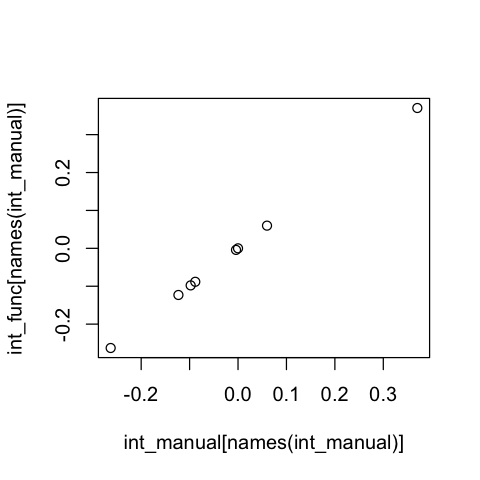

In [151]:
n_tot <- 3

#simulate data
perms <- unique_perms(n_tot)
#get unique ids
ids <- get_ids(perms)
r <- rep(1, length(ids)) + rnorm(length(ids),0 , 0.1) 
names(r) <- ids

#manual calculations
Ic <- r["control"] - r["control"]

I1 <- r["1"] - r["control"]
I2 <- r["2"] - r["control"]
I3 <- r["3"] - r["control"]

I12 <- r["12"] - r["control"] - (I1 + I2)
I23 <- r["23"] - r["control"] - (I3 + I2)
I13 <- r["13"] - r["control"] - (I1 + I3)

I123 <- r["123"] - r["control"] - (I1 + I2 + I3) - (I12 + I23 + I13)

int_manual <- c(Ic, I1,I2,I3,I12,I23,I13,I123)
int_func <- calculate_interactions(n_tot, r=r, func = f_additive)

options(repr.plot.width=4, repr.plot.height=4)

plot(int_manual[names(int_manual)],int_func[names(int_manual)])

It works!

# Experimental data
Next we apply the interaction metric to the data from the experiments

In [192]:
#load data
grw_df <- read_csv("..//results//model_summaries.csv", show_col_types = FALSE) %>%
    mutate(Control = ifelse(Complexity == 0, Mean, -Inf))%>%
    group_by(Strain) %>% 
    mutate(Control = max(Control))

head(grw_df)

Strain,PlateWell,Mean,SD,n,Amoxicillin,Chlorothalonil,Diflufenican,Glyphosate,Imidacloprid,Metaldehyde,Oxytetracycline,Tebuconazole,Complexity,Strain_nice,Control
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
100,1B10,49.08102,1.071077,4,1,0,0,1,0,1,0,0,3,IL 100,46.77685
100,1B11,46.25239,1.856007,4,1,0,0,0,0,1,1,0,3,IL 100,46.77685
100,1B2,48.35730,1.091486,4,1,0,0,0,0,0,0,0,1,IL 100,46.77685
100,1B3,44.68428,1.582045,4,0,0,0,0,0,0,1,0,1,IL 100,46.77685
100,1B4,48.31760,1.344796,4,1,0,0,0,0,1,0,0,2,IL 100,46.77685
100,1B5,48.09657,1.352457,4,0,1,0,0,0,1,0,0,2,IL 100,46.77685


In [193]:
#test on strain 100

#subset data and create id column
grw_subset <- grw_df %>% 
    filter(Strain == "100") %>%
    arrange(Complexity) %>%
    mutate(antibiotic = ifelse(Oxytetracycline == 1 | Tebuconazole == 1, "Antibiotic", "Other")) %>%
    nest(data = c(Amoxicillin, Chlorothalonil, Diflufenican, Glyphosate, Imidacloprid, 
    Metaldehyde, Oxytetracycline, Tebuconazole)) %>%
    mutate(id = unlist(map(data, function(x){paste(which(x == 1),collapse = "")})))

grw_subset %>% head()

Strain,PlateWell,Mean,SD,n,Complexity,Strain_nice,Control,antibiotic,data,id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<list>,<chr>
100,NA,46.77685,1.517388,180,0,IL 100,46.77685,Other,"0, 0, 0, 0, 0, 0, 0, 0",
100,1B2,48.35730,1.091486,4,1,IL 100,46.77685,Other,"1, 0, 0, 0, 0, 0, 0, 0",1
100,1B3,44.68428,1.582045,4,1,IL 100,46.77685,Antibiotic,"0, 0, 0, 0, 0, 0, 1, 0",7
100,1C2,47.86225,1.105722,4,1,IL 100,46.77685,Other,"0, 1, 0, 0, 0, 0, 0, 0",2
100,1C3,45.46758,3.103219,3,1,IL 100,46.77685,Antibiotic,"0, 0, 0, 0, 0, 0, 0, 1",8
100,1D2,47.50332,1.083336,4,1,IL 100,46.77685,Other,"0, 0, 1, 0, 0, 0, 0, 0",3


In [271]:
#extract ids and mean growth to caluclate interactions
r_vec <- grw_subset$Mean 
names(r_vec) <- grw_subset$id
names(r_vec)[1] <- "control"

#caluclate interactions
int_add <- calculate_interactions(8,r = r_vec, func = f_additive)
int_mult <- calculate_interactions(8,r = r_vec, func = f_multiplicative)
int_perc <- calculate_interactions(8,r = r_vec, func = f_percentchange)

#get results data frame
res_df <- data.frame(id = names(int_add), int_add, int_mult,int_perc) %>%
    full_join(grw_subset, by = "id") %>%
    select(-data)

head(res_df, 5)

,id,int_add,int_mult,int_perc,Strain,PlateWell,Mean,SD,n,Complexity,Strain_nice,Control,oxy
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,control,0.000000,1.0000000,0.00000000,vfischeri,NA,48.71414,1.3930931,180,0,V. fischeri,48.71414,0
2,1,4.314315,1.0885639,0.08856392,vfischeri,1B2,53.02845,0.9084278,4,1,V. fischeri,48.71414,0
3,2,-20.085176,0.5876931,-0.41230692,vfischeri,1C2,28.62896,6.9555612,4,1,V. fischeri,48.71414,0
4,3,3.998668,1.0820843,0.08208434,vfischeri,1D2,52.71280,0.1741107,4,1,V. fischeri,48.71414,0
5,4,3.618143,1.0742730,0.07427297,vfischeri,1E2,52.33228,0.2690890,4,1,V. fischeri,48.71414,0


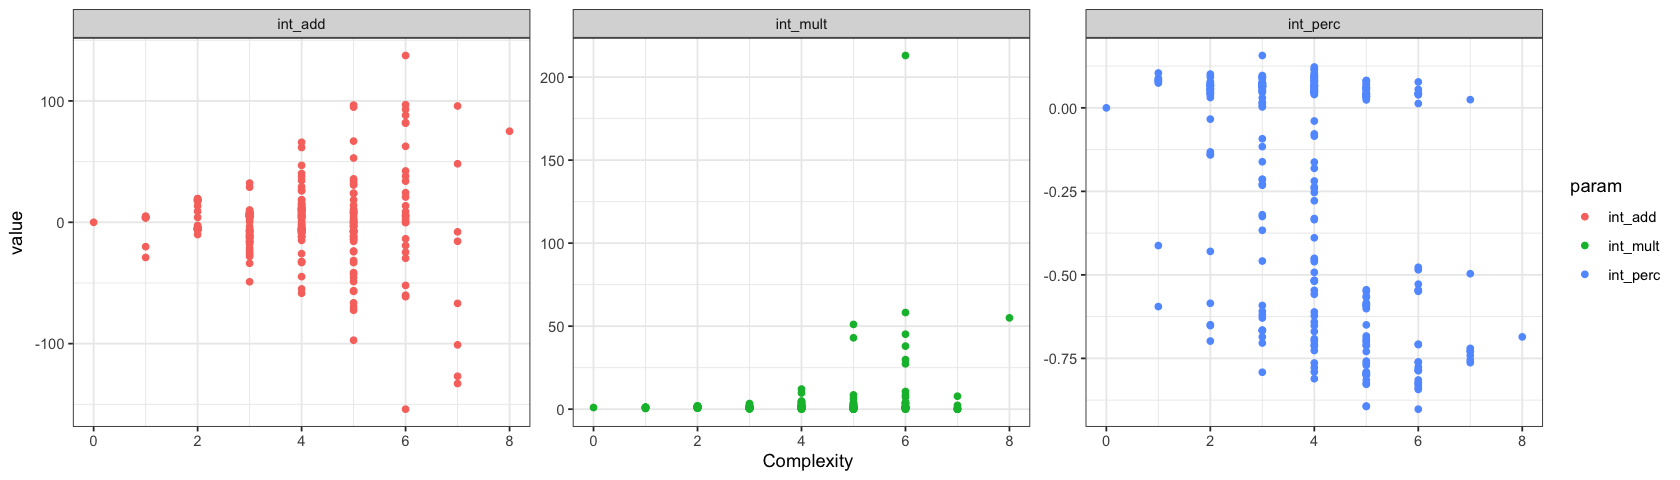

In [278]:
options(repr.plot.width=14, repr.plot.height=4)

res_df %>%
    pivot_longer(cols = 2:4, names_to = "param", values_to = "value") %>%
    ggplot(aes(x = Complexity, y = value, color = param))+
        geom_point()+
        facet_wrap(~param, scale = "free")+
        theme_bw()

Looks like we get resonable estimates from the data though there is a tendency to predict larger interaction effects as the number of stressors increases. I suspect this is because whilst growth does not change much at the higher levels (46.7 in the control and 45.1 in the 8 way experiment) the combined effects of interactions get larger as we consider more of them. 

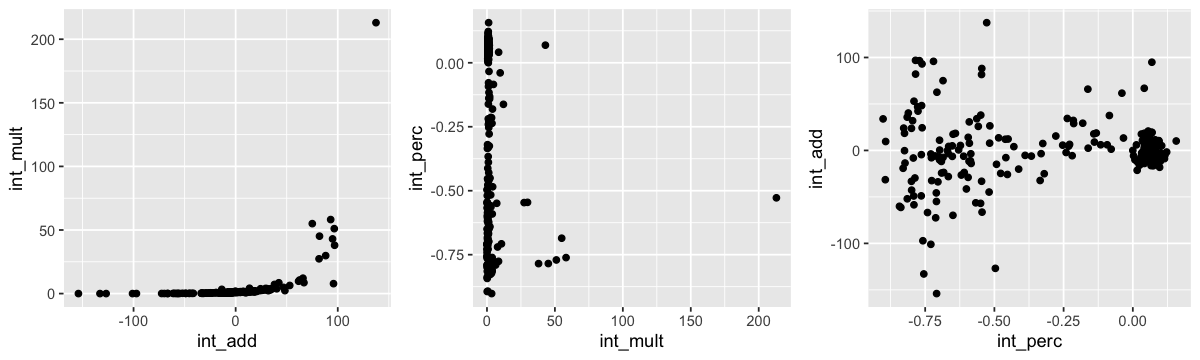

In [284]:
options(repr.plot.width=10, repr.plot.height=3)

p1 <- res_df %>% ggplot(aes(int_add, int_mult))+ geom_point()
p2 <- res_df %>% ggplot(aes(int_mult, int_perc))+ geom_point()
p3 <- res_df %>% ggplot(aes(int_perc, int_add))+ geom_point()

plot_grid(p1,p2,p3, nrow = 1)

The two methods (additive and multiplpicative) also tend to gove similiar results as evidenced by the plot shoiwng a strong correspondance between the two methods

Next we can run the analysis on all species and the mixed community

In [285]:
#running for all
#get ID cols and arrange data
gwr_df_clean <- grw_df %>% 
    arrange(Strain, Complexity) %>%
    nest(data = c(Amoxicillin, Chlorothalonil, Diflufenican, Glyphosate, Imidacloprid, 
    Metaldehyde, Oxytetracycline, Tebuconazole)) %>%
    mutate(id = unlist(map(data, function(x){ a = paste(which(x == 1),collapse = "")
                                              return(ifelse(a == "", "control", a))
                                            }))) 

gwr_df_clean %>% head()

Strain,PlateWell,Mean,SD,n,Complexity,Strain_nice,Control,data,id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<list>,<chr>
100,NA,46.77685,1.517388,180,0,IL 100,46.77685,"0, 0, 0, 0, 0, 0, 0, 0",control
100,1B2,48.35730,1.091486,4,1,IL 100,46.77685,"1, 0, 0, 0, 0, 0, 0, 0",1
100,1B3,44.68428,1.582045,4,1,IL 100,46.77685,"0, 0, 0, 0, 0, 0, 1, 0",7
100,1C2,47.86225,1.105722,4,1,IL 100,46.77685,"0, 1, 0, 0, 0, 0, 0, 0",2
100,1C3,45.46758,3.103219,3,1,IL 100,46.77685,"0, 0, 0, 0, 0, 0, 0, 1",8
100,1D2,47.50332,1.083336,4,1,IL 100,46.77685,"0, 0, 1, 0, 0, 0, 0, 0",3


In [286]:
res <- list()
Strain_vec <- unique(gwr_df_clean$Strain)
#loop over all strains and calculate
for(i in 1:length(Strain_vec)){
    grw_subset <- subset(gwr_df_clean,gwr_df_clean$Strain == Strain_vec[i])
    #make r_vec
    r_vec <- grw_subset$Mean
    names(r_vec) <- grw_subset$id

    int_add <- calculate_interactions(8,  r = r_vec, func = f_additive)
    int_mult <- calculate_interactions(8, r = r_vec, func = f_multiplicative)
    int_perc <- calculate_interactions(8, r = r_vec, func = f_percentchange)

    res_df <- data.frame(id = names(int_add), int_add, int_mult,int_perc) %>%
        full_join(grw_subset, by = "id")

    res[[i]] <- res_df
}

int_df <- bind_rows(res) 

## Additive

look relative constant though the ranges vary alot (527 for example)

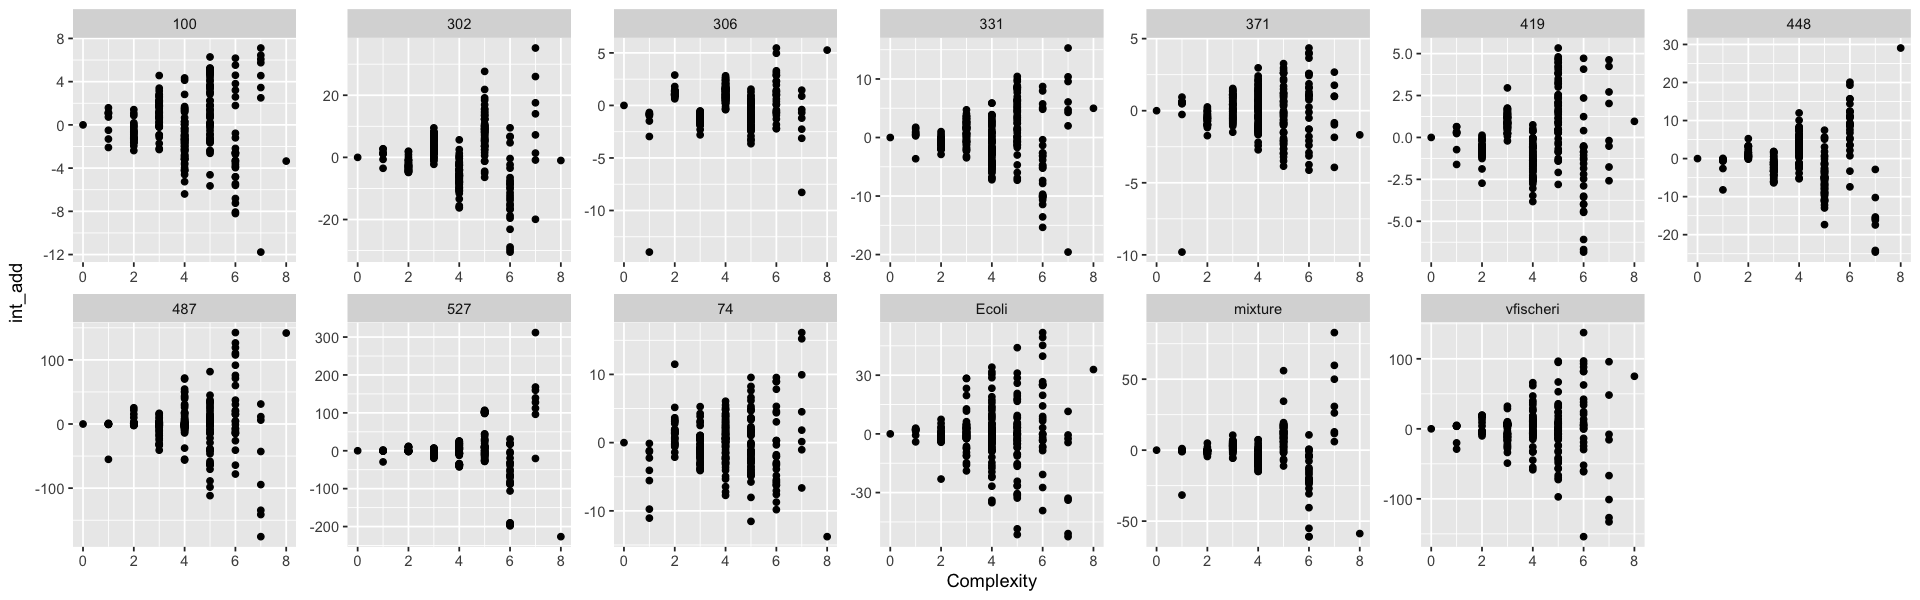

In [287]:
options(repr.plot.width=16, repr.plot.height=5)

int_df %>%
unnest(data) %>%
    ggplot(aes(Complexity,int_add))+
        geom_point()+
        facet_wrap(~Strain, scales = "free", nrow = 2)

### multiplicative
Some ok but looks like certain strains have very high estimates (527 again with interaction > 4e14!)

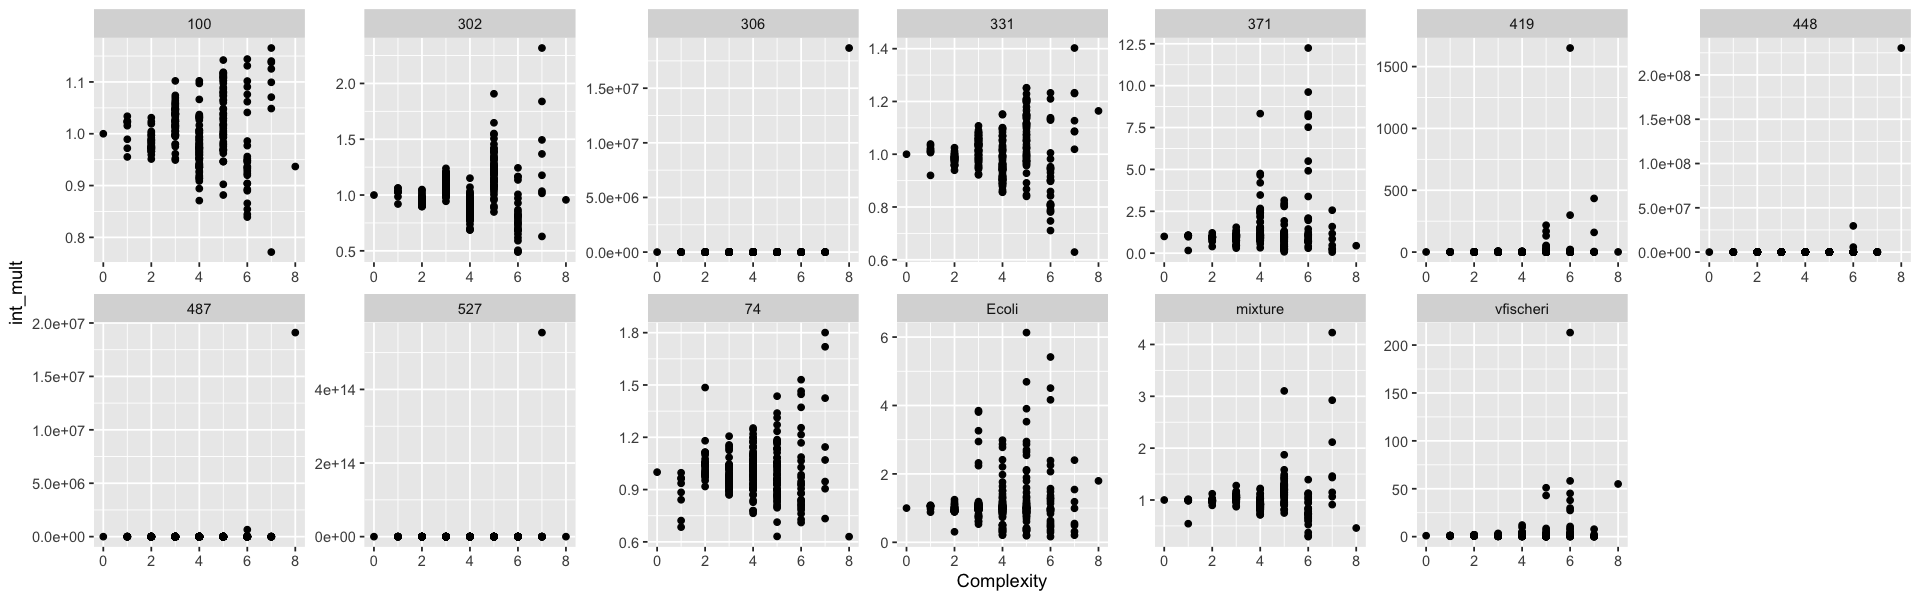

In [288]:
int_df %>%
unnest(data) %>%
    ggplot(aes(Complexity,int_mult))+
        geom_point()+
        facet_wrap(~Strain, scales = "free", nrow = 2)

# percentage
Most consistant with all estimates falling within a sensible range

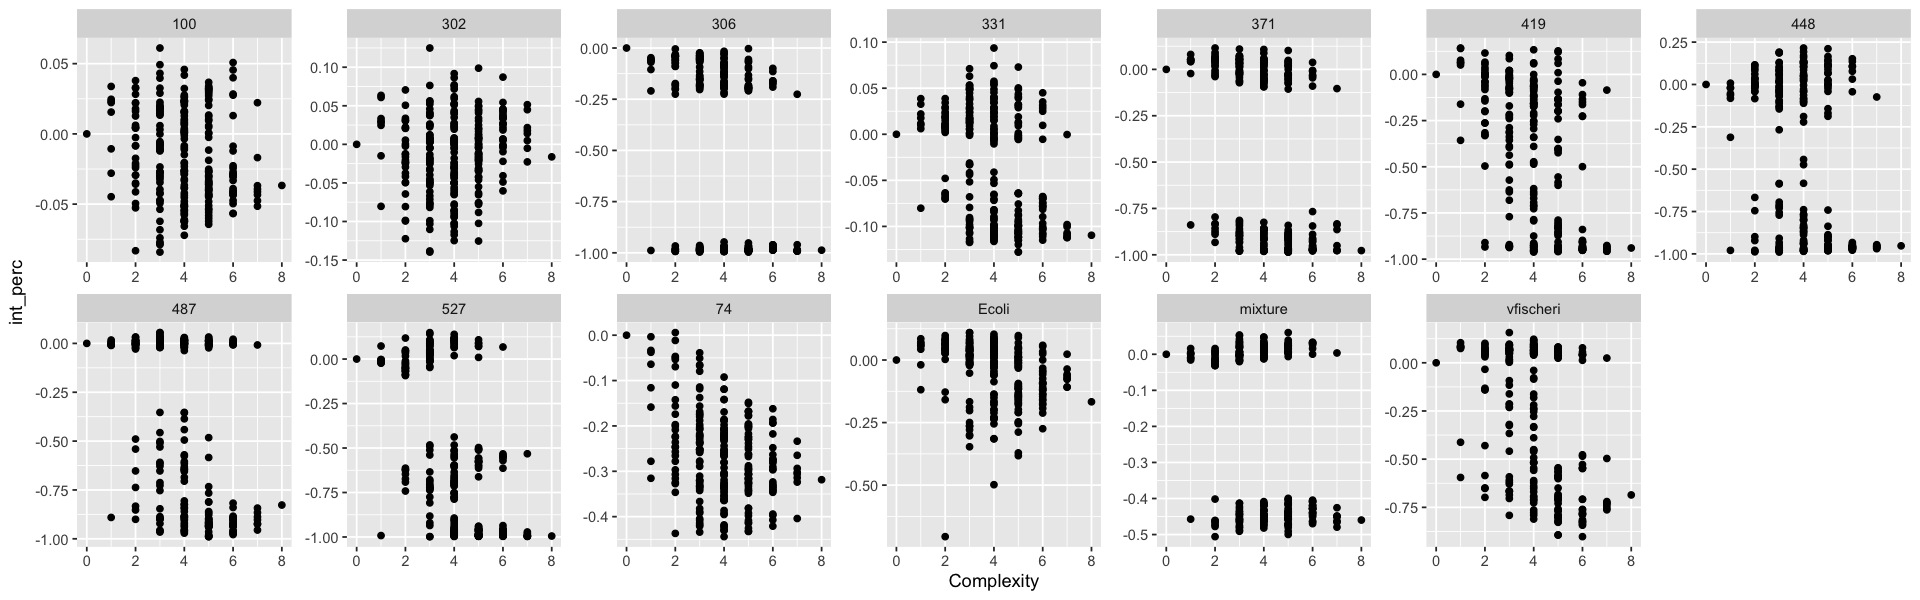

In [289]:
int_df %>%
unnest(data) %>%
    ggplot(aes(Complexity,int_perc))+
        geom_point()+
        facet_wrap(~Strain, scales = "free", nrow = 2)

# Strain 527

So why is strain 527 so weird?

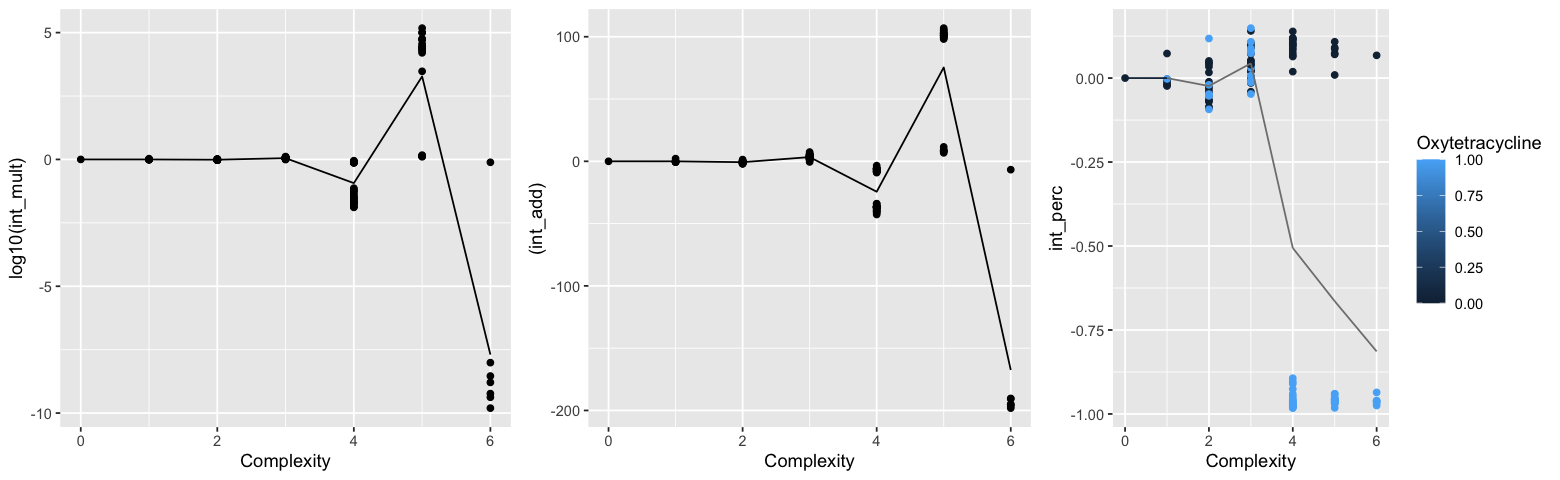

In [305]:
options(repr.plot.width=13, repr.plot.height=4)

p1 <- int_df %>% 
    filter(Strain == 527, !str_detect(id,"1"), Complexity < 7) %>%
    ggplot(aes(x=Complexity,y=log10(int_mult)))+
        geom_point()+
        stat_summary(geom = "line",fun = mean)

p2 <- int_df %>% 
    filter(Strain == 527, !str_detect(id,"1"), Complexity < 7) %>%
    ggplot(aes(x=Complexity,y=(int_add)))+
        geom_point()+
        stat_summary(geom = "line",fun = mean)

p3 <- int_df %>% 
    filter(Strain == 527, !str_detect(id,"1"), Complexity < 7) %>%
    unnest(data) %>%
    ggplot(aes(x=Complexity,y=int_perc,color = Oxytetracycline))+
        geom_point()+
        stat_summary(geom = "line",fun = mean)

plot_grid(p1,p2,p3,nrow = 1)

Looking at the interactions leading to this massive estimate it looks like there is some instability, positive estimates at one level lead to even lower estimates at the next and so on. Perhaps there is some normalisation needed to account for these effects? 

The percentage change looks more stable though the drop at the end when Oxytetracycline is included with 4 chemicals or more is strange...

# To Do

* Work out how to avoid instability?
    * consider percentage change?
* Include multiple estimates/uncertanty from lab expermiments. 
    * Could implement a bootstrapping approach
    * Include explcit model of uncertanty in interaction inference...
* Plotting
    * how to show the effects well?